# Basin Time Series

Create time series plots of the biggest basins.

In [1]:
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import patheffects
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"


## Basins

Plot the basins that are used for basin wise analysis ($\geq 200000\textrm{km}^2$)



In [4]:
THOLD = 2e5

df_basins = basins()
df_bsmall = df_basins.loc[df_basins.sum_sub_ar < THOLD]

In [5]:
# Basins to plot
BASINS = ["Amazon", "Congo", "Danube", "Ganges", "Mississippi", "Nile"]

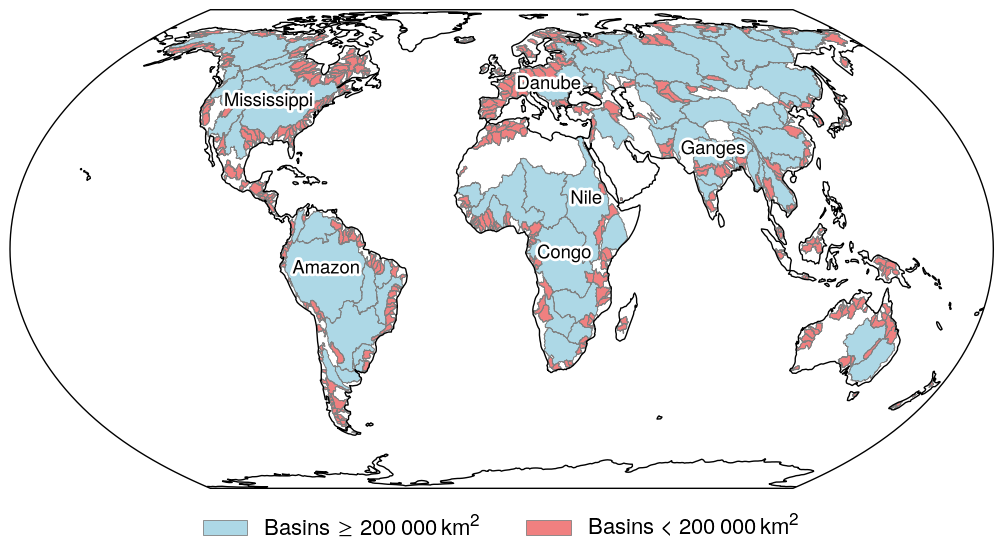

In [6]:
# Color arguments to pass to plot routine
basin_kwargs = dict(
    edgecolor="gray", linewidth=0.3, rasterized=True, facecolor="lightblue"
)
bsmall_kwargs = dict(
    edgecolor="gray", linewidth=0.3, rasterized=True, facecolor="lightcoral"
)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.EqualEarth()})
# Plot all basins
df_basins.dr.projplot(**basin_kwargs, ax=ax)
# Plot basins under size threshhold
df_bsmall.dr.projplot(
    coastlines=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    ax=ax,
    **bsmall_kwargs,
)

# Create legend with proxy artists
big_patch = mpatches.Patch(
    **basin_kwargs, label=r"Basins $\ge$ \qty{200000}{\km\squared}"
)
small_patch = mpatches.Patch(
    **bsmall_kwargs, label=r"Basins $<$ \qty{200000}{\km\squared}"
)
ax.legend(
    loc="lower center",
    handles=[big_patch, small_patch],
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
)

# Label the basins
df_btop = basins(BASINS)
df_btop["coords"] = df_btop["geometry"].apply(lambda x: x.centroid.coords[0])
for idx, row in df_btop.iterrows():
    ax.annotate(
        text=row["riverbasin"],
        xy=row["coords"],
        horizontalalignment="center",
        transform=ccrs.PlateCarree(),
        path_effects=[patheffects.withStroke(linewidth=2, foreground="white")],
        size="small",
    )

fig.savefig(FIGURE_DIR / "basins_map_named.pdf", backend="pgf")

## Time Series Plots

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [7]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
our = xr.open_zarr(our_store).twsa.rename("twsa_our")

In [8]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, our])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean

Specify variables of interest and their descriptive names:

In [9]:
vars_verbose = {
    "twsa_our": "DeepRec (Ours)",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = list(vars_verbose.keys())

target_name = "twsa_csr"
our_name = "twsa_our"

In [10]:
# Get basin names
btop_names = df_btop.riverbasin
btop_names

0          Amazon
1           Congo
2            Nile
3     Mississippi
21         Ganges
29         Danube
Name: riverbasin, dtype: object

In [11]:
ds_grid = ds_all[eval_names]
# Calculate basin averages
ds_basin = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dr.select_basins(BASINS)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)

[########################################] | 100% Completed | 13.44 s


In [12]:
# Calc yearly values
# ds_basin_yr = ds_basin.resample(time="YE").mean()
# Calc running mean
ds_basin_yr = ds_basin.rolling(time=12).mean()

In [13]:
colors = sns.color_palette("tab20")
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [14]:
# Cut the time series where our reconstruction ends
ds_basin = ds_basin.sel(time=slice(None, "2023"))
ds_basin_yr = ds_basin_yr.sel(time=slice(None, "2023"))


In [ ]:
fig, axs = plt.subplots(nrows=len(BASINS), figsize=(6, 8), sharex=True)
for ax, b_name in zip(axs.flat, btop_names):
    b_monthly = ds_basin.sel(region=b_name)
    b_yearly = ds_basin_yr.sel(region=b_name)

    (p1,) = b_monthly.twsa_our.plot(
        ax=ax, color=colors[1], linewidth=1.0, label="DeepRec (Ours), monthly"
    )
    (p2,) = b_monthly.twsa_csr.plot(
        ax=ax, color=colors[3], linewidth=1.0, label="CSR (GRACE), monthly"
    )
    (p3,) = b_yearly.twsa_our.plot(
        ax=ax, color=colors[0], label="DeepRec (Ours), 12 M rolling"
    )
    ax.set(
        xlabel=None,
        ylabel="TWS Anomaly (mm)",
        title=b_name,
        xlim=(pd.Timestamp("1940"), pd.Timestamp("2025")),
    )
    ax.yaxis.grid()

    # Add periods
    line_kwargs = dict(linestyle="dotted", linewidth=1, color="black")

    # Rec start
    t0 = pd.Timestamp("1941-01-01")
    # Train start
    t1 = pd.Timestamp("2002-03-01")
    # Val start
    t2 = pd.Timestamp("2022-01-01")
    # Val end
    t3 = pd.Timestamp("2023-12-01")

    ylim_l, ylim_u = ax.get_ylim()
    # Rec | Train
    ax.axvline(x=t1, **line_kwargs)
    # Train | Val
    ax.axvline(x=t2, **line_kwargs)

    ax.text(t0 + (t1 - t0) / 2, ylim_l, "Reconstruction", ha="center", va="top")
    ax.text(t1 + (t2 - t1) / 2, ylim_l, "Training", ha="center", va="top")
    ax.text(t2, ylim_l, "Val", ha="left", va="top")

    # Adjust lower limit relatively
    ywidth = ylim_u - ylim_l
    ax.set_ylim(ylim_l - 0.2 * ywidth)

fig.legend(handles=[p2, p1, p3], loc="upper right", bbox_to_anchor=(1.0, 0.0), ncols=3)

fig.savefig(FIGURE_DIR / "basins_timeseries.pdf", backend="pgf")
